In [84]:
import numpy as np
from docplex.mp.model import Model
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua import aqua_globals
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver, NumPyEigensolver, QAOA
from qiskit.aqua.components.optimizers import SPSA
from qiskit.circuit.library import RealAmplitudes
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.algorithms import MinimumEigenOptimizer, RecursiveMinimumEigenOptimizer, \
    MinimumEigenOptimizationResult
import matplotlib.pyplot as plt

In [85]:
machines_times = [3, 6, 2]
machines_costs = [2, 5, 1]
tasks = [6, 12, 18, 24]
paths = [[0, 1, 3], [0, 2, 3]]
d = 14

In [86]:
def get_time_matrix():
    r = []
    for i in machines_times:
        tmp = []
        for j in tasks:
            tmp.append(j / i)
        r.append(tmp)
    return np.array(r)


def get_cost_matrix(tasks_execution_times):
    m = []
    for i in range(len(tasks_execution_times)):
        tmp = []
        for j in tasks_execution_times[i]:
            tmp.append(machines_costs[i] * j)
        m.append(tmp)
    return m

In [87]:
time_matrix = np.array(get_time_matrix())
cost_matrix = np.array(get_cost_matrix(time_matrix))

In [88]:
print("Time matrix:\n {}".format(time_matrix))

Time matrix:
 [[ 2.  4.  6.  8.]
 [ 1.  2.  3.  4.]
 [ 3.  6.  9. 12.]]


In [89]:
print("Cost matrix:\n {}".format(cost_matrix))

Cost matrix:
 [[ 4.  8. 12. 16.]
 [ 5. 10. 15. 20.]
 [ 3.  6.  9. 12.]]



In this specific situation there are:


1.   two qubits for each task: **8 qubits**,
2.   first path minimum time is *1+2+4=7*. *log2(14-7)=log2(7)*: **3 qubits**,
3.   second path minimum time is *1+3+4=8*. *log2(14-8)=log2(6)*: **3 qubits**.


In total, the model has **14 variables**.

Model with:
 

1.   13 variables needs 4 GiB of RAM
2.   14 variables needs 16 GiB of RAM 
3.   15 variables needs 64 GiB of RAM



In [90]:
tasks_count = len(tasks)
machines_count = len(machines_costs)
qubits_count = tasks_count * (machines_count - 1)
slack_per_path_count = [3, 3] # Correct only for that specific problem
slacks_count = sum(slack_per_path_count)

In [91]:
# Correct only for three machines!
correct_machines = ['00', '01', '11']
machine_to_index = {'00': 0, '01': 1, '11': 2}


def get_task_subvector(vector, task_index):
    x = len(machines_costs) - 1  # When 3 machines, then subvector for each task has length of 2.
    subvector = ''
    for i in range(2 * task_index, 2 * task_index + x):
        bit_value = str(int(vector[i]))
        subvector += bit_value
    return subvector


def solution_vector_correct(vector):
    for i in range(len(tasks)):
        if get_task_subvector(vector, i) not in correct_machines:
            return False
    return True


def execution_times_not_bigger_than_deadline(vector):
    for path_index in range(0, len(paths)):
        path_time_sum = 0

        for task in paths[path_index]:
            task_machine = machine_to_index.get(get_task_subvector(vector, task))
            path_time_sum += time_matrix[task_machine, task]
        
        # Correct only for that specific problem
        if path_index == 0:
            path_time_sum += 4 * int(vector[8]) + 2 * int(vector[9]) + 1 * int(vector[10])
        elif path_index == 1:
            path_time_sum += 4 * int(vector[11]) + 2 * int(vector[12]) + 1 * int(vector[13])

        if path_time_sum != d:
            return False

    return True


def is_solution_correct(vector):
    return solution_vector_correct(vector) and execution_times_not_bigger_than_deadline(vector)

In [92]:
def get_cost_model(A):
    mdl = Model(name='cost')
    x = {(i, j): mdl.binary_var(name='x_{0}_{1}'.format(i, j)) 
        for i in range(0, tasks_count) for j in range(0, machines_count - 1)}
    x.update({i: mdl.binary_var(name='x_{0}'.format(i)) for i in range(0, slacks_count)})

    objective = A * mdl.sum(cost_matrix[2, i] * x[(i, 0)]
                            + cost_matrix[1, i] * (x[(i, 1)] - x[(i, 0)]) ** 2
                            + cost_matrix[0, i] * (1 - x[(i, 1)]) for i in range(0, tasks_count))
    mdl.minimize(objective)
    return mdl


def get_machine_usage_model(B):
    mdl = Model(name='machine_usage')
    x = {(i, j): mdl.binary_var(name='x_{0}_{1}'.format(i, j)) 
        for i in range(0, tasks_count) for j in range(0, machines_count - 1)}
    x.update({i: mdl.binary_var(name='x_{0}'.format(i)) for i in range(0, slacks_count)})

    objective = B * mdl.sum(x[(i, 0)] - x[(i, 0)] * x[(i, 1)] for i in range(0, tasks_count))
    mdl.minimize(objective)
    return mdl


def get_deadline_model(C, path_index):
    mdl = Model(name='deadline_path_{}'.format(path_index))
    x = {(i, j): mdl.binary_var(name='x_{0}_{1}'.format(i, j)) 
        for i in range(0, tasks_count) for j in range(0, machines_count - 1)}
    x.update({i: mdl.binary_var(name='x_{0}'.format(i)) for i in range(0, slacks_count)})

    starting_index = path_index * slack_per_path_count[path_index]
    slacks_sum = 4 * x[starting_index] + 2 * x[starting_index + 1] + 1 * x[starting_index + 2]
    objective = C * (d - mdl.sum(time_matrix[2, i] * x[(i, 0)]
                                 + time_matrix[1, i] * (x[(i, 1)] - x[(i, 0)])
                                 + time_matrix[0, i] * (1 - x[(i, 1)]) 
                                 for i in paths[path_index])  - slacks_sum) ** 2
    mdl.minimize(objective)
    return mdl

In [93]:
def print_solutions_with_inreasing_energy(hamiltonian):
    eigensolver = NumPyEigensolver(hamiltonian, 100)
    eigensolver_result  = eigensolver.compute_eigenvalues()

    print("Vector\t\t\tEnergy\t\t\tCorrect?")
    for eigenstate, eigenvalue in zip(eigensolver_result.eigenstates, eigensolver_result.eigenvalues):
        eigenstate, = eigenstate.sample().keys()
        eigenstate = eigenstate[::-1]
        print("{}\t\t{}\t\t{}".format(eigenstate, eigenvalue, is_solution_correct(eigenstate)))

In [94]:
def get_quadratic_problem():
    A = 1
    B = 50
    C = 100

    cost_model = get_cost_model(A)
    qp1 = QuadraticProgram()
    qp1.from_docplex(cost_model)
    H1, o1 = qp1.to_ising()

    machine_usage_model = get_machine_usage_model(B)
    qp2 = QuadraticProgram()
    qp2.from_docplex(machine_usage_model)
    H2, o2 = qp2.to_ising()

    first_path_deadline_model = get_deadline_model(C, 0)
    qp3 = QuadraticProgram()
    qp3.from_docplex(first_path_deadline_model)
    H3, o3 = qp3.to_ising()

    second_path_deadline_model = get_deadline_model(C, 1)
    qp4 = QuadraticProgram()
    qp4.from_docplex(second_path_deadline_model)
    H4, o4 = qp4.to_ising()

    H = H1 + H2 + H3 + H4
    o = o1 + o2 + o3 + o4
    qp = QuadraticProgram()
    qp.from_ising(H, o)

    print_solutions_with_inreasing_energy(H)

    return qp

In [95]:
operator = get_quadratic_problem()

Vector			Energy			Correct?
01111101011000		(-20920+0j)		True
11110001001001		(-20919+0j)		True
00110001010010		(-20918+0j)		True
01001101101000		(-20918+0j)		True
01110001011011		(-20917+0j)		True
11000001011001		(-20917+0j)		True
00000100000001		(-20917+0j)		True
11010100001000		(-20916+0j)		True
00000001100010		(-20916+0j)		True
01011101111000		(-20916+0j)		True
11110101001100		(-20916+0j)		True
01000100001010		(-20916+0j)		True
11010001101001		(-20915+0j)		True
00010100010001		(-20915+0j)		True
00110101010101		(-20915+0j)		True
01000001101011		(-20915+0j)		True
01110101011110		(-20914+0j)		True
11000101011100		(-20914+0j)		True
01010100011010		(-20914+0j)		True
00010001110010		(-20914+0j)		True
00000101100101		(-20913+0j)		True
01010001111011		(-20913+0j)		True
11010101101100		(-20912+0j)		True
01000101101110		(-20912+0j)		True
00010101110101		(-20911+0j)		True
01010101111110		(-20910+0j)		True
10110001000000		(-20860+0j)		False
10000001010000		(-20858+0j)		False
10110101000011		(-2

In [96]:
aqua_globals.random_seed = 10598
quantum_instance = QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                    seed_simulator=aqua_globals.random_seed,
                                    seed_transpiler=aqua_globals.random_seed)
reps = 2
max_trials = 1000
entanglement = 'full'

exact_mes = NumPyMinimumEigensolver()
spsa = SPSA(maxiter=max_trials)
ry = RealAmplitudes(operator.get_num_binary_vars(), reps=reps, entanglement=entanglement)
vqe_mes = VQE(quantum_instance=quantum_instance, var_form=ry, optimizer=spsa)
qaoa_mes = QAOA(quantum_instance=quantum_instance, initial_point=[0., 0.])

In [100]:
exact = MinimumEigenOptimizer(exact_mes)
vqe = MinimumEigenOptimizer(vqe_mes)
qaoa = MinimumEigenOptimizer(qaoa_mes)
recursive = RecursiveMinimumEigenOptimizer(min_eigen_optimizer=qaoa,
                                           min_num_vars=8, 
                                           min_num_vars_optimizer=exact)

In [98]:
def perform_optimization(optimization, qubit_op, name):
    result = optimization.solve(qubit_op)
    print_optimization_output(result, name)

def print_optimization_output(result, solver_name):
    print("------ %s ------" % solver_name)
    print(result)
    print("Is the found vector correct? : {}".format(is_solution_correct(result.x)))
    if type(result) is MinimumEigenOptimizationResult:
        print("Most probable sample: {}".format(max(result.samples, key=lambda item: item[2])))     
        print("Lowest energy smple: {}".format(min(result.samples, key=lambda item: item[1])))
        print("Samples count: {}\n\n".format(len(result.samples)))
        
        plt.figure(figsize=(20,10))   
        for vector, energy, _ in result.samples:
            color = "green" if is_solution_correct(vector) else "red"
            plt.axvline(x=energy, color=color)
        plt.xlabel("Energy")
        plt.ylabel("")
        plt.show()

------ Numpy Eigensolver ------
optimal function value: 40.0
optimal value: [0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0.]
status: SUCCESS
Is the found vector correct? : True
Most probable sample: ('01111101011000', 40.0, 1.0)
Lowest energy smple: ('01111101011000', 40.0, 1.0)
Samples count: 1




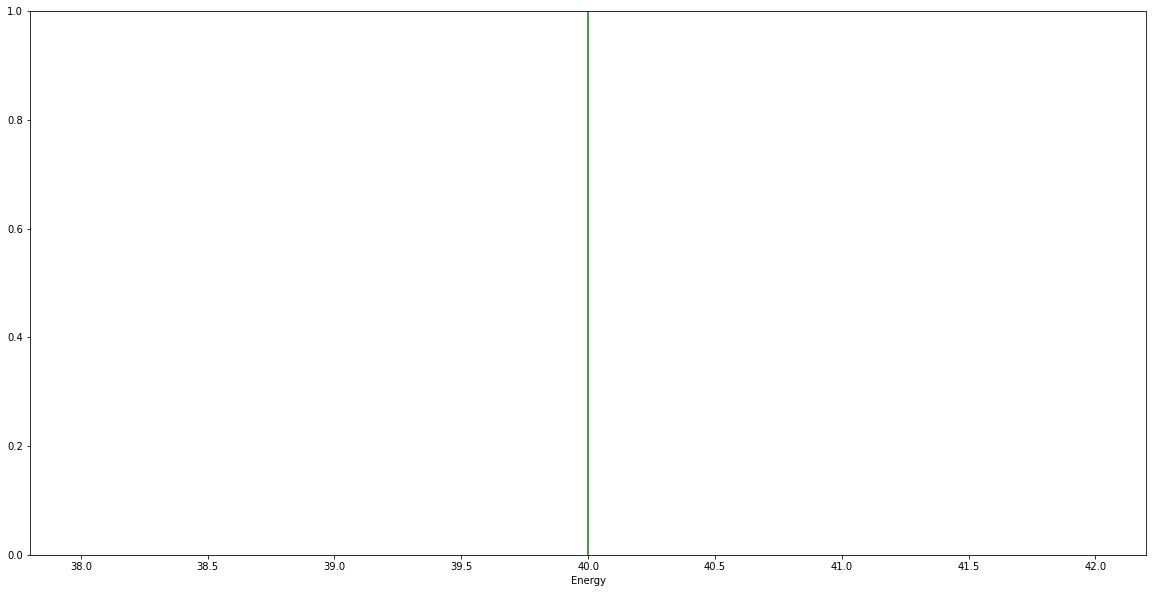

CPU times: user 527 ms, sys: 220 ms, total: 746 ms
Wall time: 512 ms


In [99]:
%%time
perform_optimization(exact, operator, "Numpy Eigensolver")

------ VQE ------
optimal function value: 40.0
optimal value: [0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0.]
status: SUCCESS
Is the found vector correct? : True
Most probable sample: ('01010111000000', 542.0, 0.41218738889216017)
Lowest energy smple: ('01111101011000', 40.0, 3.770057170031168e-05)
Samples count: 1415




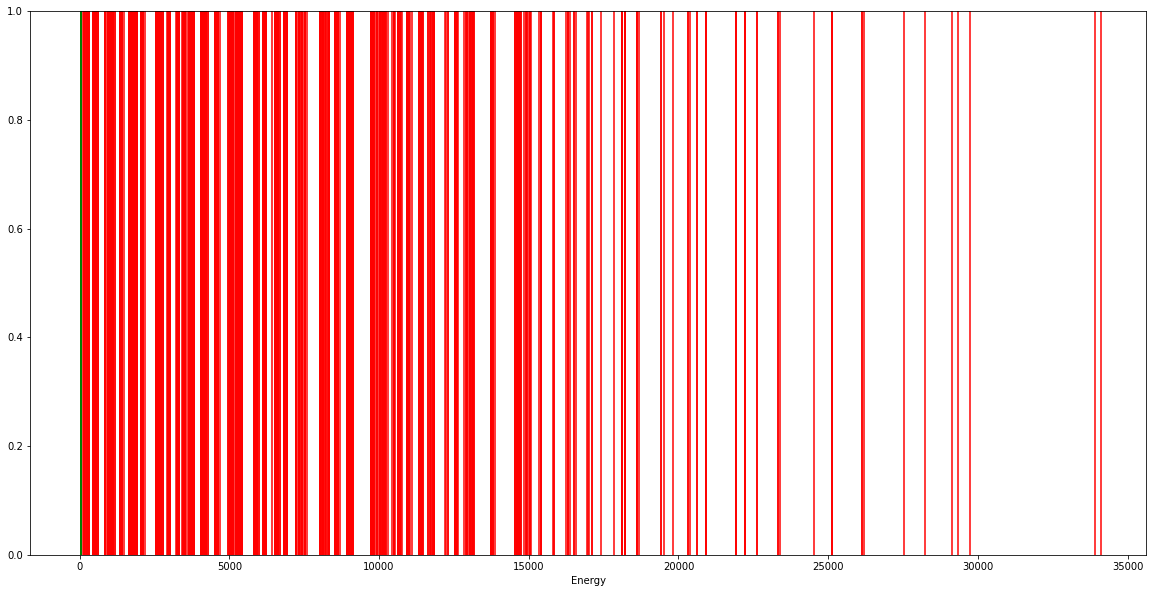

CPU times: user 1h 25min 16s, sys: 15min 53s, total: 1h 41min 9s
Wall time: 1h 10min 39s


In [17]:
%%time
perform_optimization(vqe, operator, "VQE")

------ QAOA ------
optimal function value: 40.0
optimal value: [0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0.]
status: SUCCESS
Is the found vector correct? : True
Most probable sample: ('01001101101000', 42.0, 6.103515625000003e-05)
Lowest energy smple: ('01111101011000', 40.0, 6.103515624999997e-05)
Samples count: 16384




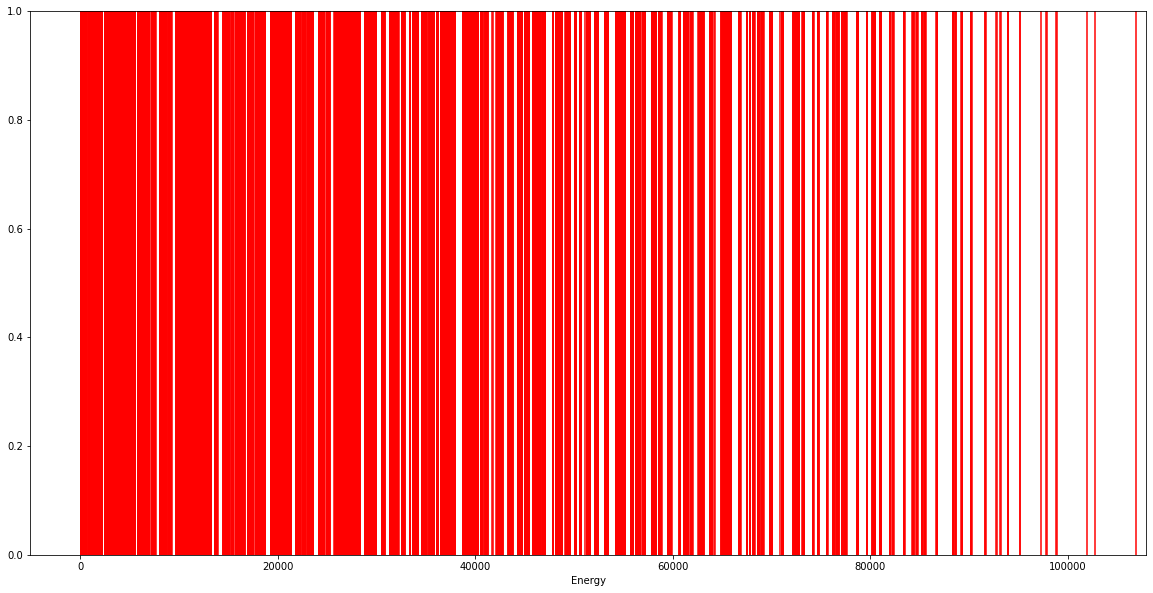

CPU times: user 18min 13s, sys: 1min 23s, total: 19min 37s
Wall time: 19min 19s


In [31]:
%%time
perform_optimization(qaoa, operator, "QAOA")

In [16]:
%%time
perform_optimization(recursive, operator, "Recursive")

------ Recursive ------
optimal function value: 42.0
optimal value: [0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0.]
status: SUCCESS
Is the found vector correct? : True
CPU times: user 24min 48s, sys: 1min 5s, total: 25min 53s
Wall time: 25min 49s
